### Dependencies

In [1]:
!pip install transformers

In [2]:
import pandas as pd
import os
from os import path
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.stem import WordNetLemmatizer 
import nltk
import numpy as np
from nltk import pos_tag
from sklearn import ensemble, metrics, model_selection, naive_bayes
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import torch
from transformers import BertTokenizer,BertForSequenceClassification, AdamW, BertConfig,get_linear_schedule_with_warmup
import time
import datetime
import random

%matplotlib inline
warnings.filterwarnings('ignore')

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
!unzip 'drive/My Drive/review_polarity.tar.zip' -d 'review/'

Archive:  drive/My Drive/review_polarity.tar.zip
  inflating: review/poldata.README.2.0  
   creating: review/txt_sentoken/
   creating: review/txt_sentoken/pos/
  inflating: review/txt_sentoken/pos/cv788_25272.txt  
  inflating: review/txt_sentoken/pos/cv264_12801.txt  
  inflating: review/txt_sentoken/pos/cv801_25228.txt  
  inflating: review/txt_sentoken/pos/cv537_12370.txt  
  inflating: review/txt_sentoken/pos/cv154_9328.txt  
  inflating: review/txt_sentoken/pos/cv659_19944.txt  
  inflating: review/txt_sentoken/pos/cv824_8838.txt  
  inflating: review/txt_sentoken/pos/cv063_28997.txt  
  inflating: review/txt_sentoken/pos/cv099_10534.txt  
  inflating: review/txt_sentoken/pos/cv112_11193.txt  
  inflating: review/txt_sentoken/pos/cv371_7630.txt  
  inflating: review/txt_sentoken/pos/cv745_12773.txt  
  inflating: review/txt_sentoken/pos/cv622_8147.txt  
  inflating: review/txt_sentoken/pos/cv282_6653.txt  
  inflating: review/txt_sentoken/pos/cv553_26915.txt  
  inflating: revie

### Data formatting

In [3]:
root_path='review/txt_sentoken/'
reviews=['pos','neg']
mydf=pd.DataFrame(columns=['filename','review','target'])
count=0

for review in reviews:
    base_path=path.join(root_path+review)
    files=os.listdir(base_path)
    for file in files:
        with open(path.join(base_path,file)) as f:
            mydf.loc[count,:]=[file,f.read().replace('\n', ''),review]
            
        count+=1

In [4]:
mydf['target']=mydf.target.replace("pos" , 1)
mydf['target']=mydf.target.replace("neg" , 0)

In [5]:
mydf.head()

,filename,review,target
0,cv480_19817.txt,the trailers and the beginning of the move sum...,1
1,cv255_13683.txt,it is often said by his fans that hal hartley ...,1
2,cv019_14482.txt,there's something about ben stiller that makes...,1
3,cv187_12829.txt,weir is well-respected in hollywood for turnin...,1
4,cv626_7410.txt,this reviewer is ignorant of what hands were r...,1


In [6]:
mydf['target'].value_counts()

1    1000
0    1000
Name: target, dtype: int64

In [7]:
# If there's a GPU available...
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [8]:
#checking the average length for fixing max seq length
mydf['sen_len']=mydf['review'].apply(lambda x: len(nltk.word_tokenize(x)))
mydf['sen_len'].mean()

762.245

In [9]:
# Load the BERT tokenizer.
MAX_LEN = 512
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 16
EPOCHS = 2
TOKENIZER = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [10]:
df_train, df_valid = model_selection.train_test_split(
    mydf,
    test_size=0.1,
    random_state=42,
    stratify=mydf.target.values
)

df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)

### Dataset class

In [11]:
class BERTDataset:
    def __init__(self,review,target):
        self.review = review
        self.target=target
        self.tokenizer = TOKENIZER
        self.max_len = MAX_LEN
    
    def __len__(self):
        return len(self.target)
    
    def __getitem__(self, item):
        
        review = str(self.review[item])
        
        tok=self.tokenizer.encode_plus(review,add_special_tokens=True,max_length=self.max_len,
                                       truncation=True,padding='max_length')
        
        return {
            'ids': torch.tensor(tok['input_ids'], dtype=torch.long),
            'mask': torch.tensor(tok['attention_mask'], dtype=torch.long),
            'targets': torch.tensor(self.target[item], dtype=torch.long)
        }

In [12]:
train_dataset = BERTDataset(
      df_train['review'].values,
      df_train['target'].values
)

train_data_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    num_workers=4
)

valid_dataset = BERTDataset(
      df_valid['review'].values,
      df_valid['target'].values
)

valid_data_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=VALID_BATCH_SIZE,
    num_workers=1
)

### Model

In [13]:
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [14]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_data_loader) * EPOCHS

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [15]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [16]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [17]:
def seed_everything(seed_val):
  # Set the seed value all over the place to make this reproducible.
  random.seed(seed_val)
  np.random.seed(seed_val)
  torch.manual_seed(seed_val)
  torch.cuda.manual_seed_all(seed_val)

In [18]:
seed_everything(2012)

###  Engine

In [24]:
# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, EPOCHS):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, EPOCHS))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_data_loader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_data_loader), elapsed))

        b_input_ids = batch['ids'].to(device)
        b_input_mask = batch['mask'].to(device)
        b_labels = batch['targets'].to(device)

        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        

        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_data_loader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in valid_data_loader:
        
        b_input_ids = batch['ids'].to(device)
        b_input_mask = batch['mask'].to(device)
        b_labels = batch['targets'].to(device)

        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        preds = torch.softmax(logits,dim=1).detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(preds, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")



======== Epoch 1 / 2 ========
Training...
  Batch    40  of    225.    Elapsed: 0:00:33.
  Batch    80  of    225.    Elapsed: 0:01:07.
  Batch   120  of    225.    Elapsed: 0:01:42.
  Batch   160  of    225.    Elapsed: 0:02:17.
  Batch   200  of    225.    Elapsed: 0:02:51.

  Average training loss: 0.18
  Training epcoh took: 0:03:13

Running Validation...
  Accuracy: 0.85
  Validation took: 0:00:08

======== Epoch 2 / 2 ========
Training...
  Batch    40  of    225.    Elapsed: 0:00:36.
  Batch    80  of    225.    Elapsed: 0:01:12.
  Batch   120  of    225.    Elapsed: 0:01:47.
  Batch   160  of    225.    Elapsed: 0:02:23.
  Batch   200  of    225.    Elapsed: 0:02:59.

  Average training loss: 0.18
  Training epcoh took: 0:03:22

Running Validation...
  Accuracy: 0.85
  Validation took: 0:00:08

Training complete!


### Loss plotting

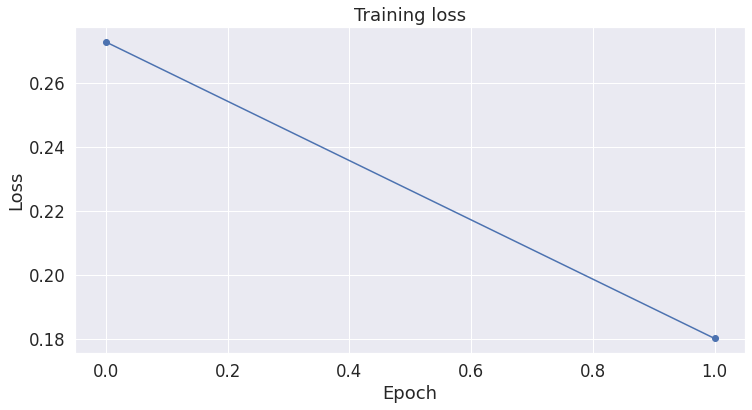

In [21]:
?# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()